In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

os.chdir('/content/drive/My Drive/Ring_sample_data')

Mounted at /content/drive/


In [ ]:
img=cv2.imread('s92.PNG',1)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Bounding Box

In [ ]:
coordinates = []
with open('s92.txt', 'r') as file:
    for line in file:
        try:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            coordinates.append((x_center,y_center))
        except ValueError:
            print(f"Skipping line: {line.strip()} - Could not convert to coordinates.")

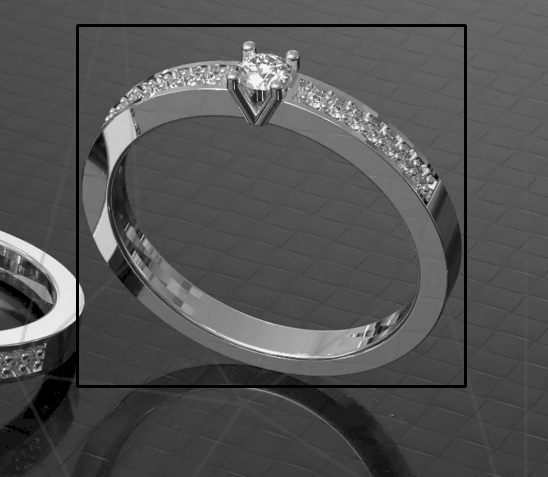

In [ ]:
img_height, img_width = gray.shape

for x_center, y_center in coordinates:
    x_center_pixel = int(x_center * img_width)
    y_center_pixel = int(y_center * img_height)

    width = int(width * img_width)
    height = int(height * img_height)

    x = int(x_center_pixel - (width / 2))
    y = int(y_center_pixel - (height / 2))
    cv2.rectangle(gray, (x, y), (x + width, y + height), (0, 255, 0), 2)


cv2_imshow(gray)

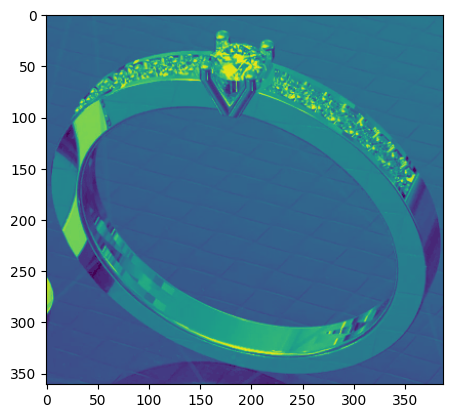

In [ ]:
cropped=gray[ y:y + height,x:x + width]
plt.imshow(cropped)

## Edge Detection

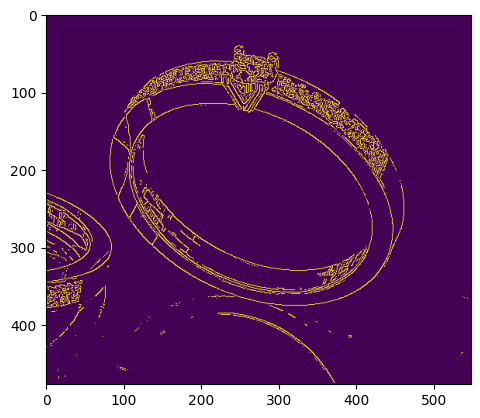

In [ ]:
edges=cv2.Canny(gray,threshold1=127,threshold2=127)
plt.imshow(edges)

## Threshold

In [ ]:
blurred=cv2.medianBlur(gray,5)

In [ ]:
thresh=cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 8)

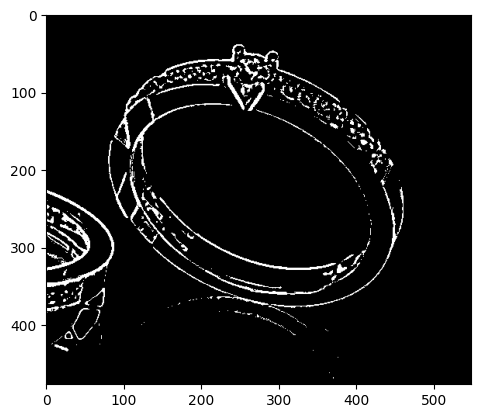

In [ ]:
plt.imshow(thresh,cmap='gray')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
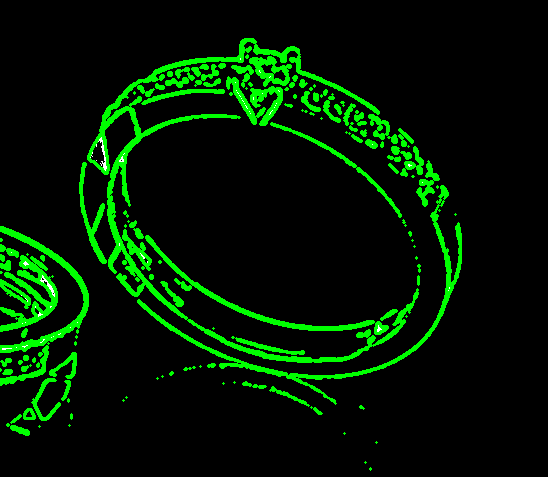

In [ ]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

## Image Segmentation

In [ ]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray

img=cv2.imread('s92.PNG',1)

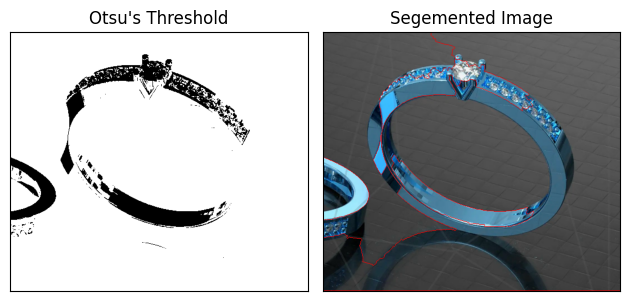

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

sure_bg = cv2.dilate(closing,kernel,iterations=3)

dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)  # Finding sure foreground area
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)  # Finding unknown region
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1   # Add one to all labels so that sure background is not 0, but 1
markers[unknown==255] = 0   # mark the region of unknown with zero
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.subplot(122),plt.imshow(img)
plt.title('Segemented Image'), plt.xticks([]), plt.yticks([])
plt.subplot(121),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's Threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

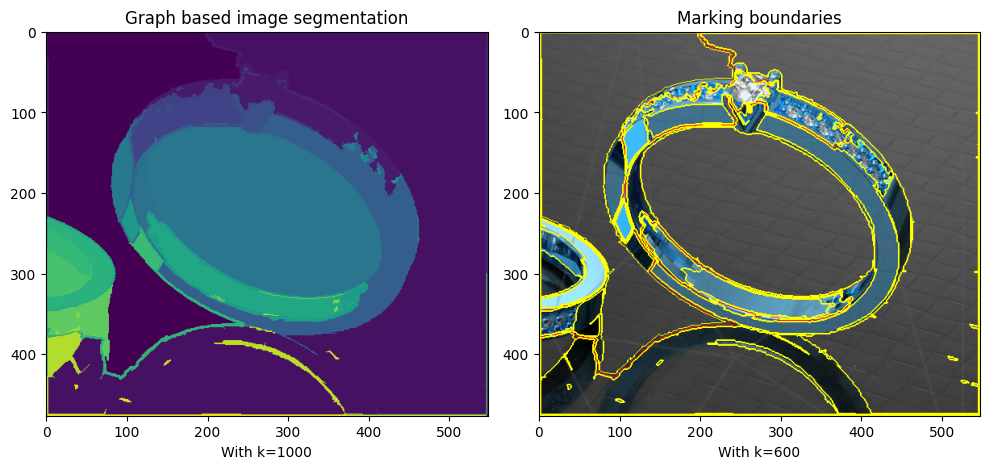

In [ ]:
res1 = felzenszwalb(img, scale=1000)
res2 = felzenszwalb(img, scale=600)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(res1)
ax1.set_xlabel("With k=1000")
ax1.set_title("Graph based image segmentation")

ax2.imshow(mark_boundaries(img, res2))
ax2.set_xlabel("With k=600")
ax2.set_title('Marking boundaries')

plt.tight_layout()

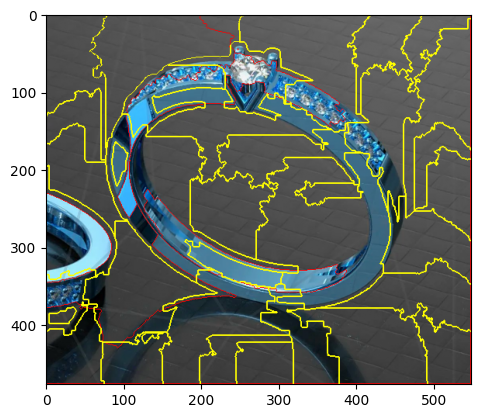

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blurred=cv2.medianBlur(gray,5)
thresh=cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 8)

kernel = np.ones((3,3),np.uint8)
process_img=cv2.dilate(thresh,kernel,iterations=3)

segments_quick=quickshift(process_img, kernel_size=10, max_dist=50, ratio=0.8,convert2lab=False)

plt.imshow(mark_boundaries(img, segments_quick))


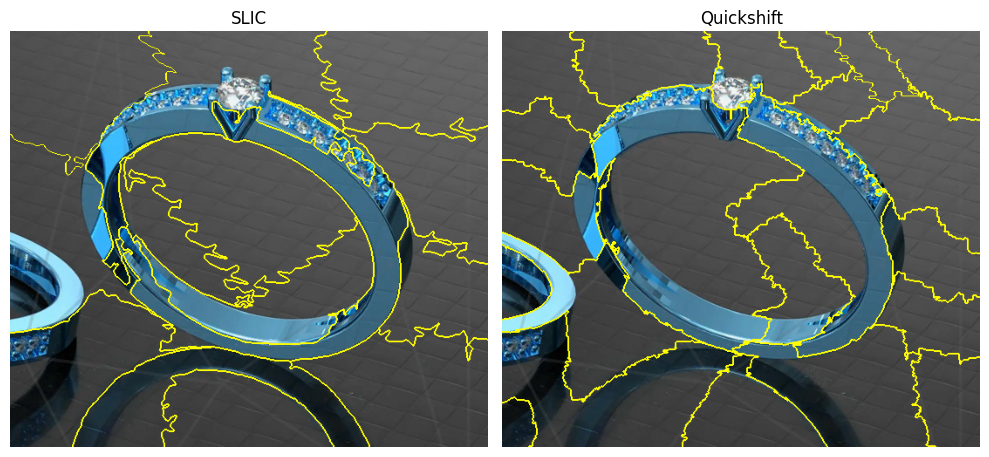

In [ ]:
segments_slic = slic(img, n_segments=19, compactness=3, sigma=2, start_label=0)
segments_quick = quickshift(img, kernel_size=10, max_dist=50, ratio=0.5)


fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(img, segments_slic))
ax[0].set_title('SLIC')
ax[1].imshow(mark_boundaries(img, segments_quick))
ax[1].set_title('Quickshift')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

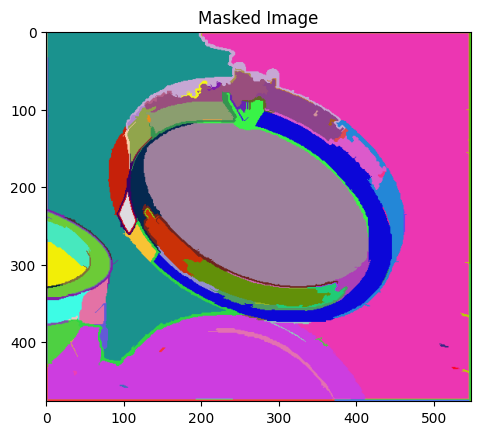

In [ ]:

segments =res2
mask = np.zeros_like(img, dtype=np.uint8)

for segment_id in np.unique(segments):
    mask[segments == segment_id] = np.random.randint(0, 255, 3)

masked_image = img.copy()
masked_image[mask != 0] = mask[mask != 0]

plt.imshow(masked_image)
plt.title('Masked Image')
plt.show()

## Histogram Analysis

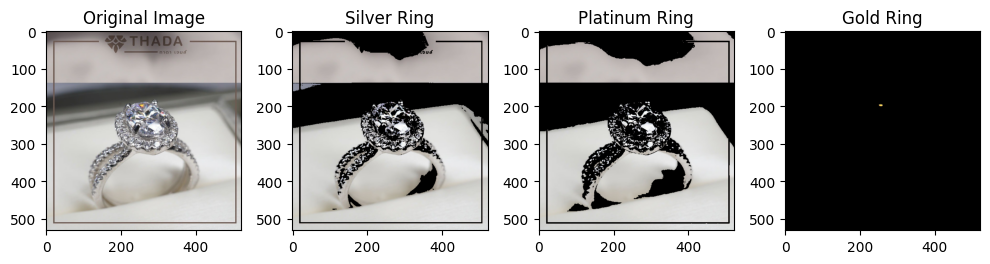

In [ ]:
img=cv2.imread('s96.PNG',1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# color ranges in HSV for better accuracy
silver_lower = np.array([0, 0, 150])
silver_upper = np.array([180, 50, 255])

platinum_lower = np.array([0, 0, 180])
platinum_upper = np.array([180, 30, 255])

gold_lower = np.array([15, 100, 100])
gold_upper = np.array([35, 255, 255])

hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

silver_mask = cv2.inRange(hsv, silver_lower, silver_upper)
platinum_mask = cv2.inRange(hsv, platinum_lower, platinum_upper)
gold_mask = cv2.inRange(hsv, gold_lower, gold_upper)

silver_ring = cv2.bitwise_and(img_rgb, img_rgb, mask=silver_mask)
platinum_ring = cv2.bitwise_and(img_rgb, img_rgb, mask=platinum_mask)
gold_ring = cv2.bitwise_and(img_rgb, img_rgb, mask=gold_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(silver_ring)
plt.title('Silver Ring')

plt.subplot(1, 4, 3)
plt.imshow(platinum_ring)
plt.title('Platinum Ring')

plt.subplot(1, 4, 4)
plt.imshow(gold_ring)
plt.title('Gold Ring')

plt.tight_layout()
plt.show()


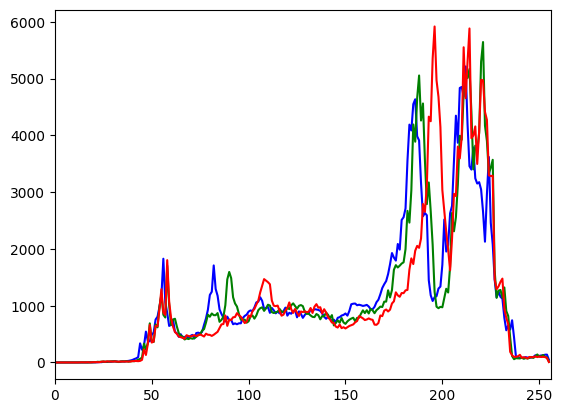

In [ ]:
color = ('b', 'g', 'r')

for i,col in enumerate(color):
  histr=cv2.calcHist([img], [i], None, [256], [0,256])
  plt.plot(histr, color=col)
  plt.xlim([0,256])
plt.show()


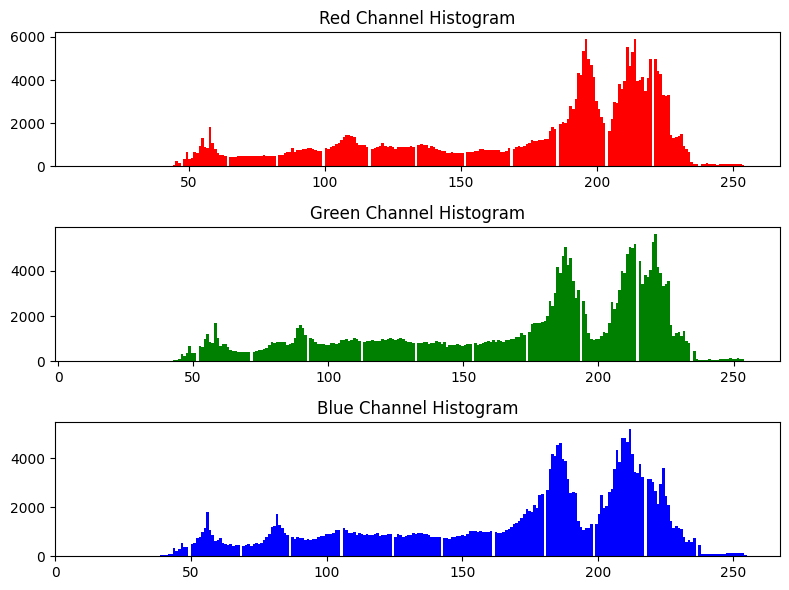

In [ ]:
r, g, b = cv2.split(img_rgb)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))

axs[0].hist(r.ravel(), bins=256, color='red')
axs[0].set_title('Red Channel Histogram')

axs[1].hist(g.ravel(), bins=256, color='green')
axs[1].set_title('Green Channel Histogram')

axs[2].hist(b.ravel(), bins=256, color='blue')
axs[2].set_title('Blue Channel Histogram')

plt.tight_layout()
plt.show()